In [33]:
# obtain data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

In [34]:
import torch 
import torch.nn as nn
import torch.nn.functional as fc

from torchvision import datasets, transforms

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1)

# define model 

class Mnist_Classification_NN(nn.Module):
    def __init__(self):
        super(Mnist_Classification_NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)    # hidden layer to hidden
        self.fc3 = nn.Linear(64, 10)     # hidden layer to output layer
    def forward(self, x):
        x = x.view(-1, 28*28)            # flatten the image
        x = fc.relu(self.fc1(x))        # activation function for hidden layer 1
        x = fc.relu(self.fc2(x))        # activation function for hidden layer 2
        x = self.fc3(x)                 # output layer (no activation function)
        return x
    
model = Mnist_Classification_NN()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [35]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

print ('done')

done


In [36]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


print('done')

done


## Sanity Check

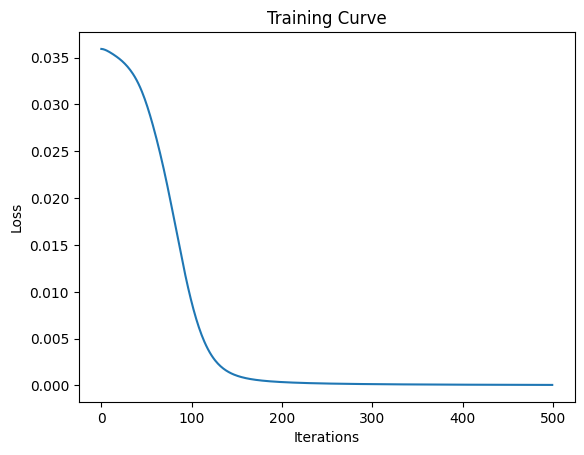

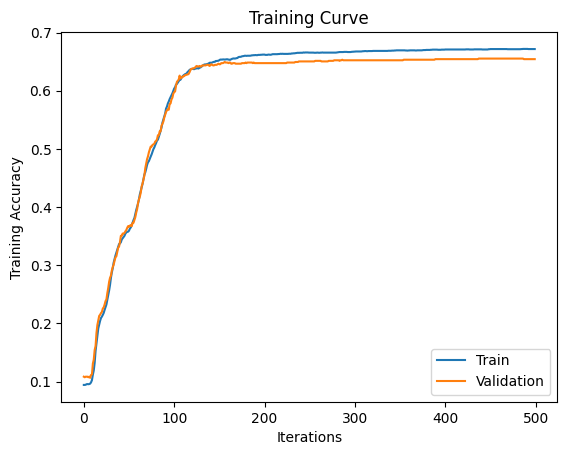

Final Training Accuracy: 0.671630859375
Final Validation Accuracy: 0.654296875
Accuracy on batch of 64:  1.0


In [18]:
#overfitting the model (sanity check)
debug_data = mnist_train[:64]
model = Mnist_Classification_NN()
train(model, debug_data, num_epochs=500)

#obtain accuracy on 64 samples
correct = 0
total = 0
for imgs, labels in torch.utils.data.DataLoader(debug_data, batch_size=64):
    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    
    #calculate number of correct predictions
    correct += pred.reshape(-1).eq(labels).sum().item()
    #correct += pred.eq(labels.view_as(pred)).sum().item() # labels.view_as(pred) forces labels to change from [64] to [64, 1].
    total += imgs.shape[0]
print('Accuracy on batch of 64: ', correct / total)

C:\Users\admin\AppData\Local\Temp\ipykernel_24432\2590425614.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  losses.append(float(loss)/batch_size)             # compute *average* loss


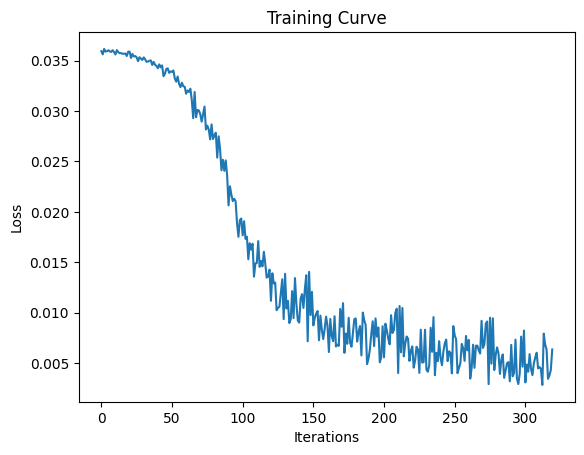

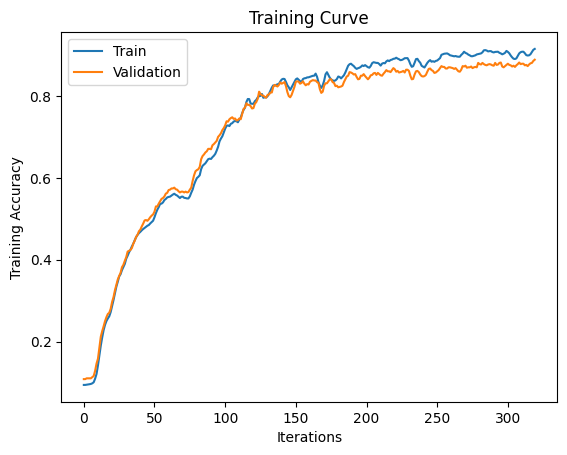

Final Training Accuracy: 0.9150390625
Final Validation Accuracy: 0.888671875


In [37]:
model = Mnist_Classification_NN()
train(model, mnist_train, num_epochs=5)

In [20]:
# save the model for next time

torch.save(model.state_dict(), 'mnist_classification_model.pth')

## Test one image

image dimensions  torch.Size([1, 28, 28])
output dimensions:  torch.Size([1, 10])
output probabilities:  tensor([[1.0096e-04, 1.3396e-06, 3.0042e-04, 2.8403e-04, 4.2983e-02, 6.9096e-04,
         8.7579e-05, 4.8366e-02, 5.3758e-03, 9.0181e-01]],
       grad_fn=<SoftmaxBackward0>) sum:  tensor(1.0000, grad_fn=<SumBackward0>)
output  torch.return_types.max(
values=tensor([[0.9018]], grad_fn=<MaxBackward0>),
indices=tensor([[9]]))
output item 9 with a probability of 0.9018105268478394 and label is 9
predicted class using argmax:  9


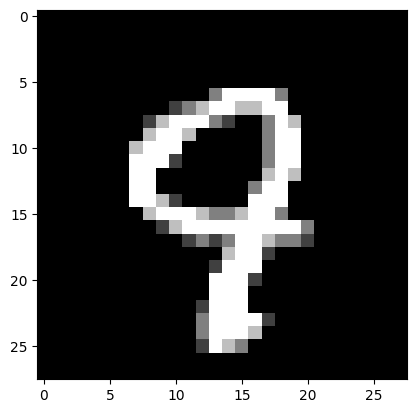

In [46]:
mnist_sample = mnist_data[19120]
img, label = list(mnist_sample)

# plot sample image

print('image dimensions ', img.shape)
plt.imshow(img.reshape(28,28), cmap='gray')


out = model(img)
prob = fc.softmax(out, dim=1)
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))


# print max index and compare with label 
print('output ', prob.max(1, keepdim=True))
print('output item', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item(), 'and label is', label)


# use of argmax to get predicted class
pred_class = torch.argmax(prob, dim=1).item()   # dim = 1 for row-wise argmax dim = 0 for column-wise argmax
print('predicted class using argmax: ', pred_class)

## Test with my own data

In [6]:
img = plt.imread(r"C:\Users\admin\Desktop\R\Projects\APS360\Tuts\tut2\test_unicorn.png")

In [7]:
print(img.dtype)

float32


In [8]:
print(img.shape)

(400, 412, 4)


In [9]:
plt.imshow(img.reshape(28,28), cmap='gray')
plt.show()

ValueError: cannot reshape array of size 659200 into shape (28,28)

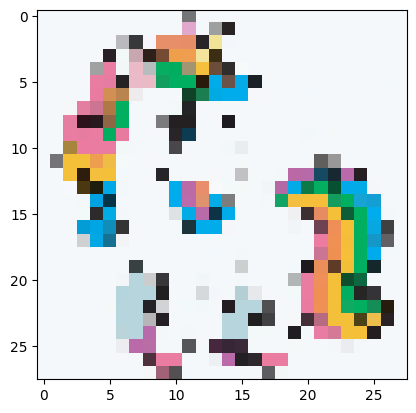

In [10]:
import cv2
img_28 = cv2.resize(img, (28,28))

plt.imshow(img_28, cmap='gray')
plt.show()

(28, 28, 4)
(14, 28, 4)
(28, 28)


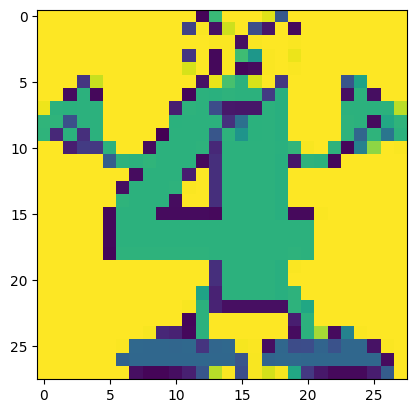

In [64]:
img_4 = plt.imread(r"C:\Users\admin\Desktop\R\Projects\APS360\Tuts\tut2\test_num_4.png")
img_4 = cv2.resize(img_4, (28,28))
print(img_4.shape)
print(img_4[::2].shape)
print(img_4[:,:,0].shape)
plt.imshow(img_4[:,:,1])
plt.show()

In [ ]:
import torch

# Shape: (1 Batch, 3 Channels, 1 Height?) -> Weird shape
x = torch.zeros(2, 3, 1) 

y = x.squeeze() # removes the empy dimensions of 1
print(y.shape)

torch.Size([2, 3])


In [58]:
img_4[...,:3].shape

(28, 28, 3)

In [59]:
img_4[...,:2].shape

(28, 28, 2)

(28, 28)


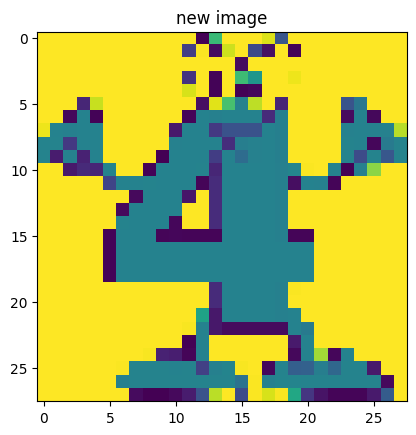

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img_gray = rgb2gray(img_4)
img_gray = img_gray.astype(np.float32)
print(img_gray.shape)
plt.title("new image")
plt.imshow(img_gray)
plt.show()

In [73]:
out = model(torch.tensor(img_gray))
prob = fc.softmax(out, dim=1)
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))


# print max index and compare with label 
print('output ', prob.max(1, keepdim=True))

output dimensions:  torch.Size([1, 10])
output probabilities:  tensor([[5.5267e-02, 7.7796e-09, 9.1699e-01, 2.3918e-02, 3.5590e-09, 2.6841e-03,
         2.4862e-05, 2.2032e-07, 1.1155e-03, 2.3766e-07]],
       grad_fn=<SoftmaxBackward0>) sum:  tensor(1., grad_fn=<SumBackward0>)
output  torch.return_types.max(
values=tensor([[0.9170]], grad_fn=<MaxBackward0>),
indices=tensor([[2]]))


In [74]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

## Otherway to modify the image



C:\Users\admin\AppData\Local\Temp\ipykernel_24432\3306364463.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(img_cropped)


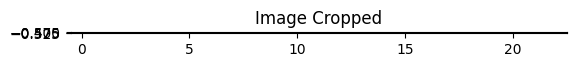

In [75]:
#cropping
img_cropped = img_gray[95:120,5:33]
plt.title("Image Cropped")
plt.imshow(img_cropped)
plt.show()

In [76]:
from skimage.transform import rescale, resize, downscale_local_mean
img_resized = resize(img_cropped, (28,28), anti_aliasing=True)

ModuleNotFoundError: No module named 'skimage'